<a href="https://colab.research.google.com/github/yeji-jeong/test/blob/master/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image 
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)



Mounted at /content/gdrive


In [55]:
train_csv = pd.read_csv('gdrive/My Drive/fashion-mnist_train.csv', encoding = 'utf-8')
test_csv = pd.read_csv('gdrive/My Drive/fashion-mnist_test.csv', encoding = 'utf-8')

In [56]:
print(torch.cuda.is_available())

True


In [57]:
#global variable 정의
EPOCHS=10
BATCH_SIZE=512

device=("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

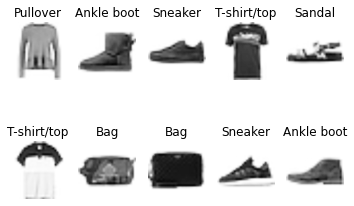

In [58]:
class FashionDataset(Dataset):
    #__init__함수는 Dataset객체가 생성 될 때 한번만 실행
  def __init__(self,data,transform=None):
      self.fashion_MNIST=list(data.values) #행들의 데이터
      self.transform=transform

      label,image=[],[]
      #csv data를 row 하나씩 list에 저장
      for i in self.fashion_MNIST:
        label.append(i[0])
        image.append(i[1:])
      self.labels=np.asarray(label)#asarray:원본이 변경될 경우, 복사본도 변경
      self.images=np.asarray(image).reshape(-1,28,28).astype("float32")
        #[batch_size, width, height, channel]
        #batch_size=-1, 자동으로 batch size를 조정하겠다

    #len():dataset의 숫자를 return
  def __len__(self):
    return len(self.images)

    #get_item():특정된 label과 image를 return
  def __getitem__(self,idx):
    label=self.labels[idx]
    image=self.images[idx]

        #transform function전에 이미지를 numpy array에서 PIL로 transform
    if self.transform is not None:
        pil_image=Image.fromarray(np.uint8(image))
        image=self.transform(pil_image)

    return image,label

#transform
#alexnet의 input size는 227*227인데, fashion mnist는 28*28이기 때문에 transform func을 통해서 resize해줘야한다.
#transform.Resize()는 PIL image에만 작동하기 때문에, numpy array를 PIL이미지로 바꿔준 것이다.

AlexTransform=transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),#PyTorch에서 주로 텐서 형태의 데이터로 작업, 입력데이터가 Numpy배열 또는 PIL이미지인 경우 ToTensor를 사용하여 텐서 형식으로 변환가능
    transforms.Normalize((0.1307,), (0.3081,))#MNIST data set의 mean과 std
])

#DataLoader
#학습에 쓰일 데이터 전체를 보관했다가, train함수가 batch 하나를 요구하면
#batch size 개수 만큼 데이터를 꺼내서 준다
train_loader=DataLoader(
    FashionDataset(train_csv,transform=AlexTransform),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader=DataLoader(
    FashionDataset(test_csv,transform=AlexTransform),
    batch_size = BATCH_SIZE, shuffle = True)

#Show Images
#image를 보여주기 위해 normalize된 이미지를 unnormalize한 후 그래프에 plot하는 함수
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img*1307 + 0.3081  # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
#iter를 사용하여 trainloade의 iterator를 만들고, next함수를 사용하여 interator의 첫번째 데이터부터 차례대로 가져온다.
dataiter = iter(train_loader)
images, labels = next(dataiter)


for i in range(10):
  plt.subplot(2,5,i+1)
  img_grid= torchvision.utils.make_grid(images[i])
  matplotlib_imshow(img_grid)
  plt.title(class_names[labels[i]])
  plt.axis("off")

In [63]:
class fasion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=3, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) #overlapping pooling
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 3, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384,3 , 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out)) 
        out = F.dropout(out, 0.5) #dropout
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

model = fasion_mnist_alexnet().to(device)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())
import torchsummary


In [67]:
#train function
def train(model, device, train_loader, optimer, epoch):
    #모델을 학습모드로 변환
    model.train()
    #내부적으로 iterator에 포함된 index가 존재. train()함수가 데이터를 요구하면 사전에 저장된 batch size만큼 return
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()#모든 model parameter의 gradient를 0으로 설정(다음 step에서는 다음 step에서만의 변화량을 구하도록 함)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()#backward로 미분하여 손실함수에 끼친 영향력(변화량)을 구하고 
        optimizer.step() #optimizer.step을 통해 손실함수를 최적화하도록 파라미터를 업데이트
        #batch_idx가 0-117,118//30=3.933
        #이를 통해 4등분하여서 25%,50%,75%이렇게 나타내려고 하는 것(3.9이므로 마지막 값은 안나옴)
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [68]:


#test function
def test(model, device, test_loader,images):
    model.eval()
    test_loss = 0
    correct = 0
    sum=0
    a=[] 
    b=[]
    c=[]
    wrong_pred,wrong_target=[],[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]#max함수 안의 1은 어느 방향으로 max값을 찾을지를 의미, 출력된 max는 (값,index)인데 필요한 부분은 index(라벨)이므로 1의 값을 가져온다.
            #0-9사이에서 가장 가능성이 높다고 예측한 답을 구한다
            correct += pred.eq(target.view_as(pred)).sum().item()
            #답이 맞다면 correct가 올라가게 되어 최종 출력되는 정확도 올라감
            #pred.eq(target.view_as(pred))는 pred배열과 data가 일치하느냐, sum을 붙임으로 인해 개수의 합을 숫자로
            for i in range(len(target)):
              if pred[i]!=target[i]:
                wrong_pred.append(class_names[pred[i]])
                wrong_target.append(class_names[target[i]])
        print("misclassfication된 Sandal 개수 : ",wrong_target.count("Sandal"),"/",len(wrong_target))
        for i in range(len(wrong_target)):
            if wrong_target[i]=="Sandal":
              if wrong_pred[i]=="Sneaker":
                 b.append(i)
              if wrong_pred[i]=="Ankle boot":
                 c.append(i)
        print("Sandal을 Sneaker로 misclassfication :{}/{} ({:.0f}%)".format(len(b),wrong_target.count("Sandal"),100*len(b)/wrong_target.count("Sandal"))) 
        print("Sandal을 Ankle boot로 misclassfication :{}/{} ({:.0f}%)".format(len(c),wrong_target.count("Sandal"),100*len(c)/wrong_target.count("Sandal")))

        

        test_loss /= len(test_loader.dataset)  # /= :왼쪽 변수에 오른쪽 값을 나누고, 그 결과를 왼쪽 변수에 할당 
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)
 
      
        

In [69]:
#train
for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader,images)

Train Epoch:1 [14848/60000 (25%)]	Loss: 0.386435
Train Epoch:1 [30208/60000 (50%)]	Loss: 0.368129
Train Epoch:1 [45568/60000 (75%)]	Loss: 0.311988
misclassfication된 Sandal 개수 :  31 / 1179
Sandal을 Sneaker로 misclassfication :24/31 (77%)
Sandal을 Ankle boot로 misclassfication :5/31 (16%)

Test set: Average loss: 0.3157, Accuracy: 8821/10000 (88%)

Train Epoch:2 [14848/60000 (25%)]	Loss: 0.325871
Train Epoch:2 [30208/60000 (50%)]	Loss: 0.281835
Train Epoch:2 [45568/60000 (75%)]	Loss: 0.229018
misclassfication된 Sandal 개수 :  35 / 1101
Sandal을 Sneaker로 misclassfication :23/35 (66%)
Sandal을 Ankle boot로 misclassfication :7/35 (20%)

Test set: Average loss: 0.2917, Accuracy: 8899/10000 (89%)

Train Epoch:3 [14848/60000 (25%)]	Loss: 0.272956
Train Epoch:3 [30208/60000 (50%)]	Loss: 0.268955
Train Epoch:3 [45568/60000 (75%)]	Loss: 0.245811
misclassfication된 Sandal 개수 :  29 / 959
Sandal을 Sneaker로 misclassfication :19/29 (66%)
Sandal을 Ankle boot로 misclassfication :7/29 (24%)

Test set: Average loss: 0.